ライブラリのインポート

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

Kalman Filterのクラス定義

In [2]:
class KalmanFilter:
    def __init__ (self,  A, B, C, Sigma_x, Sigma_y, mu, sigma):
        """
        State Space Model is
        x_(t+1) = Ax_t + Bu_t + w_t (State equation)
        y_t         = Cx_t + v_t               (Observation equation)
        w_t ~ N(0, Q), v_t ~ N(0, R)
        """
        self.A = A
        self.B = B
        self.C = C
        self.Q = Sigma_x
        self.R = Sigma_y
        
        # Variables of Kalman Filter
        self.sigma = sigma
        self.mu = mu
        
        #self.x_hat =  (np.random.multivariate_normal(self.mu.T[0], self.sigma, 1))[0][:, None]
        
    def predict (self, u):
        self.mu_hat = self.A.dot(self.mu) + self.B.dot(u)
        self.sigma_hat = self.Q + multi_dot([self.A, self.sigma, self.A.T])
        
        self.x_hat = (np.random.multivariate_normal(self.mu_hat.T[0], self.sigma_hat, 1))[0][:, None]
        
        return (self.x_hat)
        
    def update (self, y):
        y_tilda = y - self.C.dot(self.mu_hat) # Observation error
        S = multi_dot([self.C, self.sigma_hat, self.C.T]) + self.R # Covariance of the observation error
        K = multi_dot([self.sigma_hat, self.C.T, np.linalg.inv(S)]) # Optimal kalman gain
        
        self.mu = self.mu_hat + K.dot(y_tilda) # update mean
        self.sigma = self.sigma_hat - multi_dot([K, self.C, self.sigma_hat]) # update covariance
        

LQGのクラス定義

In [3]:
class LQG:
    def __init__(self, A, B, C, Q, R, T):
        self.L = np.zeros([B.shape[1], B.shape[0], T])
        self.S_next = Q
        self.s_next = 0
        
        self.Q = Q
        self.R = R
        self.T = T
        
    def create(self, A, B, C):
        for i in range(self.T - 1, -1, -1):
            self.L[:, :, i] = np.linalg.inv(multi_dot([B.T, self.S_next, B]) + self.R).dot(multi_dot([B.T, self.S_next.T, A]))
            self.s_next = multi_dot([C, self.S_next, C.T]) + self.s_next
            #self.S_next = self.Q + multi_dot([self.L[:, :, i].T, self.R, self.L[:, :, i]]) + multi_dot([A.T, self.S_next, B, self.L[:, :, i]]) + multi_dot([self.L[:, :, i].T, B.T, self.S_next, B, self.L[:, :, i]])
            self.S_next = self.Q + multi_dot([self.L[:, :, i].T, self.R, self.L[:, :, i]]) + multi_dot([A.T, self.S_next, A]) - 2 *  multi_dot([A.T, self.S_next, B, self.L[:, :, i]]) + multi_dot([self.L[:, :, i].T, B.T, self.S_next, B, self.L[:, :, i]])
            
        return self.L
    

Linear Gaussian State Space modelの関数定義

In [4]:
def LinearGausseModel(A, B, C, Sigma_x, Sigma_y, x, u):
    mean_x = ((A.dot(x) + B.dot(u))).T[0]
    cov_x    = np.dot(Sigma_x, Sigma_x.T)
    
    mean_y = ((C.dot(x))).T[0]
    cov_y    =  np.dot(Sigma_y, Sigma_y.T)

    x_next = (np.random.multivariate_normal(mean_x, cov_x, 1))[0][:, None]
    y = (np.random.multivariate_normal(mean_y, cov_y, 1))[0][:, None]

    return x_next, y

実行

In [5]:
T = 100

# Weights of LQG
D = np.eye(2) * 1
Q = np.array([[1, 0], [0, 1]]) * 1
R = np.array([[1]]) * 0.01

# Matrices of LGSSM
A = np.array([[0.5, 0.3], [0, 1]])
B = np.array([2, 1])[:, None]
C = np.array([[0.1, 5], [1., 0.3]])#[None, :]
Sigma_x = np.array([[1, 0], [0, 1]]) 
#Sigma_x = D.dot(D.T)
Sigma_y = np.array([[1, 0], [0, 1]]) * 1

# Initial mean and covariance of Kalman filter
mu_kf = np.array([0, 0])[:, None]
sigma_kf = np.array([[0, 0], [0, 0]])

# Create Kalman filter
kf = KalmanFilter(A, B, C, Sigma_x, Sigma_y, mu_kf, sigma_kf)

# Create controler by LQG
lq = LQG(A, B, D, Q, R, T)
L_t = lq.create(A, B, D)

# action
u = np.array([0])[:, None]

# save variable
x = np.zeros([A.shape[0], 1, T])
x_kf = np.zeros([x.shape[0], x.shape[1], T])
y = np.zeros([C.shape[0], 1, T])
u = np.zeros([1, 1, T])

# initial state
x[:, :, 0] = np.array([50, -30])[:, None]

# Compute Kalman Filter
for i in range(0, T, 1):
    
    x_kf[:, :, i] = kf.predict(u[:, :, i])
    
    #u =  rd.uniform(-10, 10, 1)[:, None]
    u[:, :, i] = -L_t[:, :, i].dot(x_kf[:, :, i])
    #print u
       
    if i < T - 1:
        x[:, :, i + 1], y[:, :, i] =  LinearGausseModel(A, B, C, Sigma_x, Sigma_y, x[:, :, i], u[:, :, i])
    else:
        _, y[:, :, i] =  LinearGausseModel(A, B, C, Sigma_x, Sigma_y, x[:, :, i], u[:, :, i])
    
    kf.update(y[:, :, i])
    
print 'end'

end


In [6]:
LinearGausseModel(A, B, C, Sigma_x, Sigma_y, x[:, :, i], u[:, :, i])

(array([[ 0.19680809],
        [ 0.8315766 ]]), array([[-0.56514479],
        [ 2.43374061]]))

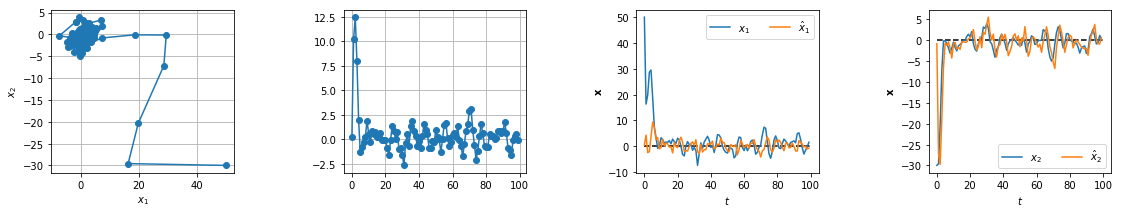

In [7]:
plt.figure(figsize = (19, 3))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

plt.subplot(141)
plt.plot(x[0, 0, :], x[1, 0, :], '-o')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()

plt.subplot(142)
#plt.plot(x_kf[0, 0, :], x_kf[1, 0, :], '-o')
plt.plot(u[0, 0,:] , '-o')
#plt.xlabel("$\hat{x}_1$")
#plt.ylabel("$\hat{x}_2$")
plt.grid()

plt.subplot(143)
plt.plot(x[0, 0, :], label = "$x_1$")
plt.plot(x_kf[0, 0, :], label = "$\hat{x}_1$")
plt.hlines(0, 0, T, linestyles="dashed")
plt.xlabel("$t$")
plt.ylabel("$\mathbf{x}$")
plt.legend(ncol = 2)

plt.subplot(144)
plt.plot(x[1, 0, :], label = "$x_2$")
plt.plot(x_kf[1, 0, :], label = "$\hat{x}_2$")
plt.hlines(0, 0, T, linestyles="dashed")
plt.xlabel("$t$")
plt.ylabel("$\mathbf{x}$")
plt.legend(ncol = 2)

'''
plt.subplot(144)
plt.plot(y[0, 0, :], label = 'truth')
#plt.plot(obs_kf[0, 0, :], label = 'prediction')
plt.xlabel("$t$")
plt.ylabel("$\hat{\mathbf{y}}$")
'''

plt.show()